In [1]:
# We always start with appropriate imports; note the use of the IPython magic
# command to set up Matplotlib within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.fftpack import fftshift, ifftshift
import cmath

In [2]:
import numpy.fft as fft
import scipy.ndimage as nd
import scipy.misc as misc
from math import pi

## Double slits diffraction pattern

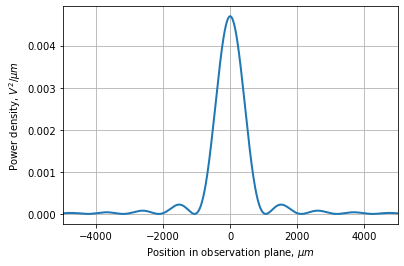

In [3]:
# Create a sinc function to operate on numpy arrays
def sinc(x):
    if (x != 0):
        # Prevent divide-by-zero
        return np.sin(np.pi * x) / (np. pi * x)
    else:
        return 1
sinc = np.vectorize(sinc)

amplitude    = 1     # Volt / sqrt(micron)
slitWidth    = 5     # microns
wavelength   = 0.532 # microns
propDistance = 10000 # microns (= 10 mm)

x = np.arange(-10000, 10000, 1)
F = sinc(slitWidth * x / wavelength / propDistance)
I = amplitude / (wavelength * propDistance) * (slitWidth * F)**2

plt.plot(x, I, linewidth = 2)
plt.xlim((-5000, 5000))
plt.xlabel(r'Position in observation plane, $\mu m$')
plt.ylabel('Power density, $V^2 / \mu m$')
plt.grid(True)
plt.show()

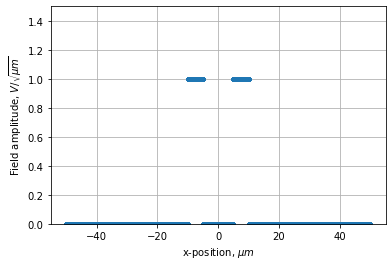

In [11]:
xNew        = np.linspace(-50, 50, num = 2**20)
fieldNew    = np.zeros(xNew.size, dtype='complex128') # Ensure the field is complex

fieldNew[np.logical_and(xNew > -2*slitWidth , xNew <= -slitWidth )] = amplitude + 0j
fieldNew[np.logical_and(xNew > slitWidth , xNew <= 2*slitWidth )] = amplitude+ 0j

plt.plot(xNew, np.abs(fieldNew), '.')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.ylim((0, 1.5))
plt.grid(True)
plt.show()

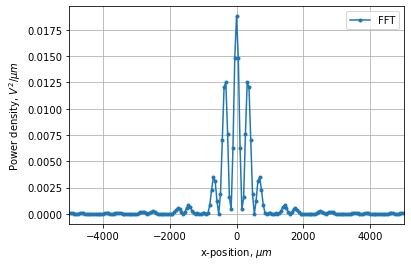

In [5]:
dxNew = xNew[1] - xNew[0] # Spatial sampling period, microns
fS    = 1 / dxNew         # Spatial sampling frequency, units are inverse microns
f     = (fS / xNew.size) * np.arange(0, xNew.size, step = 1) # inverse microns
f_half=f.size/2
xPrimeNew   = np.hstack((f[-524288:] - fS, f[0:524288])) * wavelength * propDistance

diffractedField = dxNew * np.fft.fftn(fftshift(fieldNew)) # The field must be rescaled by dx to get the correct units

IrradTheoryNew = amplitude / (wavelength * propDistance) * \
    (slitWidth * sinc(xPrimeNew * slitWidth / wavelength / propDistance))**2
IrradFFTNew    = fftshift(diffractedField * np.conj(diffractedField)) / wavelength / propDistance

plt.plot(xPrimeNew, np.abs(IrradFFTNew), '.-', label = 'FFT')
#plt.plot(xPrimeNew, IrradTheoryNew, label = 'Theory')
plt.xlim((-5000, 5000))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Power density, $V^2 / \mu m$')
plt.grid(True)
plt.legend()
plt.show()

## Double slit diffraction simulation

In [17]:
def explicit_2D_wave_eq_update(theta_n, theta_nm1,r):
    """Update wave equation using simple finite difference 
    approach in 2D.  Assumes periodic boundary conditions.
    Inputs: 
    theta_n   Wave at time t_n     = n*dt
    theta_nm1 Wave at time t_{n-1} = (n-1)*dt
    r         Constant (c dt/dx)**2
    Output:
    theta at time t_{n+1} = (n+1)*dt """
    theta_np1 = 2.0*theta_n - theta_nm1 + r*r*(np.roll(theta_n,1,axis=0) - 
                                               2.0*theta_n + np.roll(theta_n,-1,axis=0) 
                                              ) + r*r*(np.roll(theta_n,1,axis=1) - 
                                               2.0*theta_n + np.roll(theta_n,-1,axis=1) )
    return theta_np1


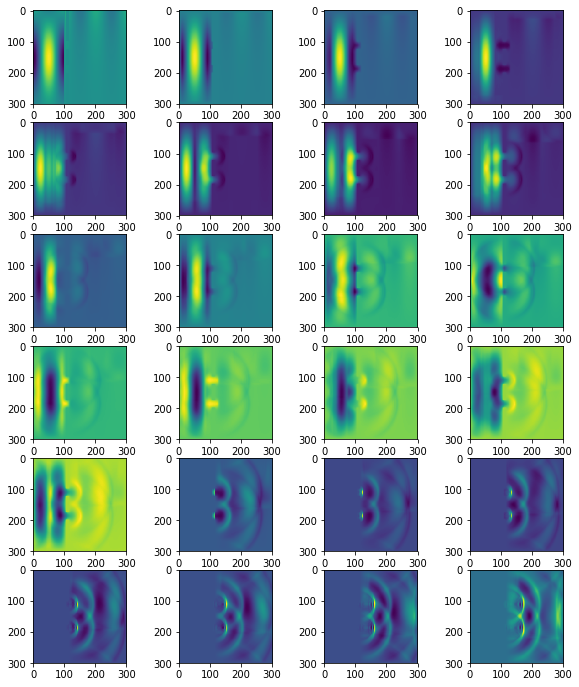

In [18]:
# Define number of points
N = 100
# Initialise
wavelength = 1 #m
wavevector = 2*np.pi/wavelength
frequency = 1 # Hz
ang_freq = 2*np.pi*frequency
speed = wavelength*frequency
dx = wavelength/N # Also dy
x = np.arange(0,3*wavelength,dx)
y = np.arange(0,3*wavelength,dx)
x2d, y2d = np.meshgrid(x,y)
#######################################################


#Wave simulation for double slit with cosine waves 
#################################################
wavelength =1  # sets wavelength to be 1m
wavevector= 2*np.pi/wavelength  # just setting the k value
frequency = 1
ang_freq= 2*np.pi*frequency  # omega value 
speed=wavelength*frequency
r=0.9

N=100

dx=wavelength/N

xpoints= np.arange(0,3*wavelength,dx)
ypoints= np.arange(0,3*wavelength,dx)
xaxis, yaxis = np.meshgrid (xpoints,ypoints)
midy=1.5*wavelength
sigma=1.0
#starts with sine wave in x, with Gaussian enevlope in y
t=0
theta_0 = np.cos(wavevector*xaxis-ang_freq*t)*np.exp(-(yaxis-midy)**2/sigma)
#
theta_0[:,N:] = 0.0
theta_0[:,0]=0.0
r=0.2
dt=r*dx/speed
t+=dt
theta_1=np.cos(wavevector*xaxis-ang_freq*t)*np.exp(-yaxis-midy**2/sigma)
theta_0[:,N:] = 0.0  # from first entry to Nth entry
theta_1[:,N]=0.0
theta_1[:,0]=0.0
#boundary conditions at the top and bottom 
theta_0[0,:] = 0.0  # from first entry to Nth entry
theta_0[3*N-1,:]=0.0
theta_1[0,:]=0.0
theta_1[3*N-1,:]=0.0
iters=1200
fig=plt.figure(figsize=(10,12))
index=1
midn= int(3*N/2)
for n in range (iters):
    if n>2*iters/3:
        theta_0[:,:midn-45]=0.0
        theta_1[:,:midn-45]=0.0
        
        
    theta_0[midn+50:,midn-45:midn-35]=0.0
    theta_1[midn+50:,midn-45:midn-35]=0.0
    theta_0[:midn-50,midn-45:midn-35]=0.0
    theta_1[:midn-50:,midn-45:midn-35]=0.0
    theta_0[midn-25:midn+25,midn-45:midn-35]=0.0
    theta_1[midn-25:midn+25,midn-45:midn-35]=0.0
    theta_0[:,3*N-1] = 0.0
    theta_1[:,3*N-1] = 0.0
        # update
    theta_next = explicit_2D_wave_eq_update(theta_1,theta_0,r)
        #boundary conditions:hard walls at top
    theta_next[0,:] = 0.0
    theta_next[3*N-1,:]=0.0
        #update
    theta_0=theta_1
    theta_1 = theta_next
    if n%50==0:
        ax=fig.add_subplot(6,4,index)
        ax.imshow(theta_next)
        index+=1
###########################################################
